# Monte-Carlo Version

We compare `dim` statistics between two groups.  Thus, we have 2 sets of $d \in (1,...,dim)$ auto-correlated normal distributions $\phi_{d}=\phi(\mu_{d},\sigma_{d})$.  Thus $d$ indexes a pair of distributions $A$ and $B$ that have equal variance.

In order to inspect the false-positive rate and the FWER, we set the "true" effect to zero.  In this case we know the null hypothesis is true.


In [95]:
import statsmodels.stats.power as smp
from scipy.linalg import cholesky
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# if using a Jupyter notebook, includue:
%matplotlib inline

In [137]:
# Set globals
dim = 5 # the number of tests to compare
alpha = 0.05 # the false positive rate
power = 0.80 # 1-false negative rate
sigma = 10  # standard deviation
mde = 0.10  # the relative minimum detectable effect
mu_a = 100
mu_b = mu_a*(1+mde)
d = (mu_b-mu_a)/sigma # standardized effect size
n_mc = 1000  # monte-carlo trials
corr = 0.9  # the correlation between the normal values 

# do power calculation for number of observations required to detect minimum detectable effect
n_obs = math.ceil(smp.TTestIndPower().solve_power(effect_size = d, 
                                         power = power, 
                                         alpha = alpha))
n_obs

17

In [127]:
# set the true effect to 0
effect = 0
mu_b = (1+effect)*mu_a

mean_a = mu_a*np.ones(dim)
mean_b = mu_b*np.ones(dim)
corr_mat = corr*np.ones([dim,dim],float)
np.fill_diagonal(corr_mat,1.0)

# Compute the (upper) Cholesky decomposition matrix
upper_chol = cholesky(corr_mat)

tts = np.empty((0,dim), int)
ttp = np.empty((0,dim), int)

for i in range(n_mc):
    # Create two sets of dim correlated series of random values
    v_a = np.random.normal(0.0, sigma, size=(n_obs, dim)) @ upper_chol + mean_a
    v_b = np.random.normal(0.0, sigma, size=(n_obs, dim)) @ upper_chol + mean_b

    # append dim p-values to pvs
    ttr = scipy.stats.ttest_ind(v_a, v_b)
    tts = np.vstack([tts, ttr.statistic])
    ttp = np.vstack([ttp, ttr.pvalue])

# Now decide to reject/not based on the simple p-value < alpha rule

# Print the individual rejection rates for each test
print(sum(ttp < alpha)/len(ttp))

# Calculate the average rejection rate for all tests; if effect=0, this is the FPR
reject_ratio = np.mean(sum(ttp < alpha)/len(ttp))
print(reject_ratio)

# Calculate the FWER
fwer = sum(np.any(ttp<alpha, axis=1))/len(ttp)
print(fwer)


[0.052 0.041 0.049 0.049 0.05 ]
0.0482
0.224


In [138]:
# set the true effect to the mde
effect = mde
mu_b = (1+effect)*mu_a

mean_a = mu_a*np.ones(dim)
mean_b = mu_b*np.ones(dim)

corr_mat = corr*np.ones([dim,dim],float)
np.fill_diagonal(corr_mat,1.0)

# Compute the (upper) Cholesky decomposition matrix
upper_chol = cholesky(corr_mat)

tts = np.empty((0,dim), int)
ttp = np.empty((0,dim), int)

for i in range(n_mc):
    # Create two sets of dim correlated series of random values
    v_a = np.random.normal(0.0, sigma, size=(n_obs, dim)) @ upper_chol + mean_a
    v_b = np.random.normal(0.0, sigma, size=(n_obs, dim)) @ upper_chol + mean_b
    
    # append dim p-values to pvs
    ttr = scipy.stats.ttest_ind(v_a, v_b)
    tts = np.vstack([tts, ttr.statistic])
    ttp = np.vstack([ttp, ttr.pvalue])

# Now decide to reject/not based on the simple p-value < alpha rule
# print(ttp)

# Print the individual rejection rates for each test
print(sum(ttp < alpha)/len(ttp))

# Calculate the average rejection rate for all tests;
#   if effect=0, this is the FPR
#   if effect=mde, this is the TNR (power)
reject_ratio = np.mean(sum(ttp < alpha)/len(ttp))
print(reject_ratio)



[0.805 0.812 0.802 0.823 0.817]
0.8118000000000001


## T-statistic distributions
Do the t-tstatistics maintain the correlation that was introduced into the data?

In [139]:
print(corr)
print(np.corrcoef(tts[:,0], tts[:,1]))

0.9
[[1.         0.89259282]
 [0.89259282 1.        ]]


Are T-statistics distributed normally?  Plot marginals of the joint distribution.

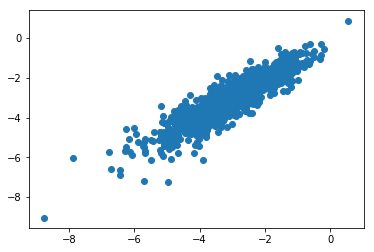

In [141]:
plt.scatter(tts[:,0], tts[:,2])